In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import sys
from matplotlib import pyplot as plt
import numpy as np
import h5py
import keras
from keras.models import load_model
from keras import backend as K
from tqdm import tqdm

import os
from os.path import join

# Set the learning phase to false, the model is pre-trained.
K.set_learning_phase(False)

In [3]:
ROOT = join('/home','qsb', 'Repos', 'Winter_School_QSB_2018')
sys.path.append(ROOT)
os.chdir(ROOT)

In [4]:
from QSB import cca_core as cca
from QSB import dft_ccas as dft_cca
from QSB.loaders import load_mnist_data, sample_mnist_balanced
from QSB.extraction import extract_representations

# Load data and 2 models

In [5]:
x_train, x_test, y_train, y_test, y_test_int = load_mnist_data()
model_a = load_model(join(ROOT, 'Advanced1', 'models','mnist_conv_deep_slowlearning01.h5') )
model_b = load_model(join(ROOT, 'Advanced1', 'models','mnist_conv_deep_slowlearning12.h5') )

In [6]:
nsamples = 200
samples, labels = sample_mnist_balanced(x_test, y_test_int, nsamples)

# Extract representations

In [7]:
layers_outs_a = extract_representations(model_a, samples)
layers_outs_b = extract_representations(model_b, samples)

In [8]:
model_a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
__________

In [9]:
layers_names = [l.name for l in model_a.layers]

In [ ]:
selected_outs_a = [(layers_names[i],layers_outs_a[i]) for i in range(len(layers_names)) 
                 if 'conv'  in layers_names[i] 
                 or 'pool'  in layers_names[i]
                 or 'dense' in layers_names[i]  ]

selected_outs_b = [(layers_names[i],layers_outs_b[i]) for i in range(len(layers_names)) 
                 if 'conv'  in layers_names[i] 
                 or 'pool'  in layers_names[i]
                 or 'dense' in layers_names[i]  ]

In [11]:
selected_layers_labels = [l for (l,_) in selected_outs_a]

del layers_outs_a
del layers_outs_b

# Compute SVCCA

In [14]:
x = np.reshape(selected_outs_a[-3][1], (nsamples*10,-1)).T
y = np.reshape(selected_outs_a[-2][1], (nsamples*10,-1)).T

print(x.shape)
print(y.shape)
svcca = cca.get_cca_similarity(x,y, threshold=0.98, compute_dirns=True)

(1024, 2000)
(1024, 2000)
adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!


In [17]:
print(svcca.keys())

dict_keys(['neuron_coeffs1', 'neuron_coeffs2', 'cca_coef1', 'cca_coef2', 'x_idxs', 'y_idxs', 'mean', 'sum', 'cca_dirns1', 'cca_dirns2'])


In [23]:
m = np.min([svcca['cca_coef1'].shape[0], svcca['cca_coef2'].shape[0] ] ) 
print(m)

1011


In [24]:
z1 = svcca['cca_dirns1']
z2 = svcca['cca_dirns2']

(1011, 2000)

In [27]:
corr = []
for i in range(m):
    corrcoef = np.corrcoef(z1[i,:],z2[i,:])
    corr.append( np.abs( corrcoef[0,1]) ) 

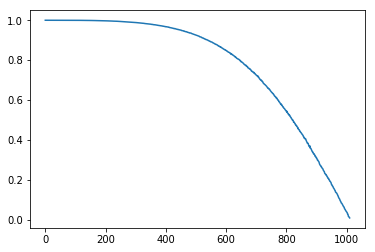

In [28]:
plt.plot(corr)

In [ ]:
similarity = np.mean(corr)

# Implement SVCCA similarity

$\bar{\rho} = \frac{1}{\min(m_1, m_2)} \sum_i \text{corr}(v^i, w^i)$

In [32]:
def similarity(x,y):
    x = np.reshape(x, (x.shape[0],-1)).T
    y = np.reshape(y, (y.shape[0],-1)).T
    svcca = cca.get_cca_similarity(x,y, threshold=0.98, compute_dirns=True)

    m = np.min([svcca['cca_coef1'].shape[0], svcca['cca_coef2'].shape[0] ] ) 
    z1 = svcca['cca_dirns1']
    z2 = svcca['cca_dirns2']
    corr = []
    for i in range(m):
        corrcoef = np.corrcoef(z1[i,:],z2[i,:])
        corr.append( np.abs( corrcoef[0,1]) ) 
    sim = np.mean(corr)
    return (sim, corr)

In [33]:
svccasim = similarity(selected_outs_a[-3][1],selected_outs_b[-3][1])

adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!


In [46]:
selected_layers_labels

['conv2d_1',
 'conv2d_2',
 'max_pooling2d_1',
 'conv2d_3',
 'conv2d_4',
 'max_pooling2d_2',
 'dense_1',
 'dense_2',
 'dense_3']

In [44]:
_ = [print(similarity(selected_outs_a[-i][1],selected_outs_b[-i][1])[0]) 
     for i in range(1,4)]

adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!
0.7894069299734376
adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!
0.7219379483445123
adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!
0.729077049756801


In [47]:
?dft_cca

In [53]:
df = dft_cca.fourier_ccas(selected_outs_a[-5][1], selected_outs_b[-5][1])

In [65]:
df['cca_coef1'][1].shape

(62,)

array([0.995647  , 0.98599443, 0.98045153, 0.97707013, 0.97128259,
       0.96560701, 0.96249072, 0.95521937, 0.94251041, 0.93086189,
       0.91277756, 0.89898229, 0.89008239, 0.86061897, 0.85581898,
       0.84341978, 0.82523445, 0.82244539, 0.80833636, 0.78899465,
       0.7752133 , 0.76498285, 0.74875242, 0.73575627, 0.7077754 ,
       0.68711009, 0.6636627 , 0.64955886, 0.62269324, 0.59368508,
       0.58663698, 0.57641738, 0.56712717, 0.54859275, 0.51041163,
       0.49838226, 0.48070188, 0.45322244, 0.44525792, 0.41286495,
       0.39273183, 0.37854241, 0.36601372, 0.35716343, 0.33676635,
       0.31959974, 0.30502604, 0.2905432 , 0.26135502, 0.25279744,
       0.2228298 , 0.21113562, 0.1917097 , 0.16220046, 0.13350765,
       0.12223125, 0.10678658, 0.07242684, 0.06165309, 0.04669872,
       0.04320718, 0.0087032 , 0.001     ])